In [1]:
!pip install geopandas
!pip install rasterio

### Importacion de librerias
- Esta celda importa librerías necesarias. Las bibliotecas como `numpy`, `matplotlib`, o `pandas` son comúnmente utilizadas para manipulación de datos, visualización, y análisis numérico.
- Esta celda genera una visualización. `plot` se usa comúnmente para gráficos de líneas, `imshow` para mostrar imágenes (por ejemplo, matrices o resultados de sensores).


In [10]:
#import required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from skimage.feature import match_template
import numpy as np
from PIL import Image
from rasterio.mask import mask
from rasterio.plot import plotting_extent

### Carga de Shp y Ortomosaico
- Se carga los puntos de muestreo realizados en un documentos shp, donde se deben seleccionar puntos aleatorios en los centroides de plantas.
- Se carga el ortomosaico a analizar para el conteo de plantas.



In [11]:
#### open point shapefile
pointData = gpd.read_file('Shp/Puntos 04_05.shp')
print('CRS of Point Data: ' + str(pointData.crs))

#open raster file
papaRaster = rasterio.open('Rst/Ortomosaico_2.tif')
# print CRS and other information about the raster
print('CRS of Raster Data: ' + str(papaRaster.crs))
print('Number of Raster Bands: ' + str(papaRaster.count))
print('Interpretation of Raster Bands: ' + str(papaRaster.colorinterp))

CRS of Point Data: COMPD_CS["MAGNA-SIRGAS / Colombia Bogota zone + unknown",PROJCS["MAGNA-SIRGAS / Colombia Bogota zone",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4.59620041666667],PARAMETER["central_meridian",-74.0775079166667],PARAMETER["scale_factor",1],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]],VERT_CS["unknown",VERT_DATUM["unknown",2005],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP]]]
CRS of Raster Data: PROJCS["MAGNA-SIRGAS / Colombia Bogota zone",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,

In [12]:
# Cargar shapefile del área de estudio
area_estudio = gpd.read_file("Shp/Shp Lote.shp")
area_estudio = area_estudio.to_crs(papaRaster.crs)  # Asegurar mismo CRS


In [13]:
# Extraer geometría del área de estudio
geoms = area_estudio.geometry.values
geoms = [geom.__geo_interface__ for geom in geoms]



In [14]:
# Recortar el raster con el shapefile
ortomosaico_clip, ortomosaico_transform = mask(papaRaster, geoms, crop=True)



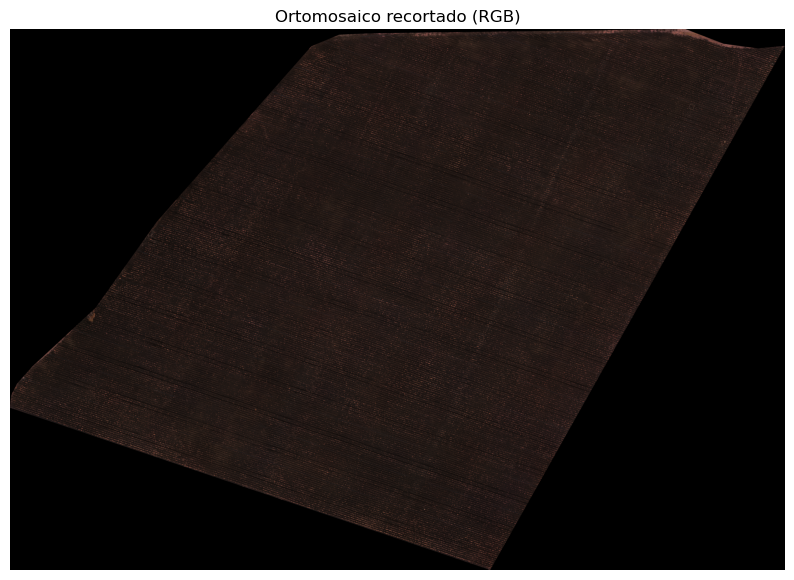

In [15]:
# Mostrar el resultado
# Seleccionar 3 bandas para RGB (ajusta si tus bandas están en otro orden)
rgb = np.stack([
    ortomosaico_clip[4],  # Banda 1 - R
    ortomosaico_clip[2],  # Banda 2 - G
    ortomosaico_clip[1]   # Banda 3 - B
], axis=-1)

# Normalizar entre 0 y 1 si es necesario
rgb = rgb.astype('float32')
rgb /= np.max(rgb)

# Mostrar imagen RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("Ortomosaico recortado (RGB)")
plt.axis('off')
plt.show()

In [19]:
# Definir los metadatos del nuevo raster
meta = papaRaster.meta.copy()
meta.update({
    "driver": "GTiff",
    "height": ortomosaico_clip.shape[1],
    "width": ortomosaico_clip.shape[2],
    "transform": ortomosaico_transform,
    "count": ortomosaico_clip.shape[0]
})

# Guardar el raster recortado
with rasterio.open("Rst/Mosaico_recortado_04_05.tif", "w", **meta) as dst:
    dst.write(ortomosaico_clip)

### Mostrar puntos y ráster en un gráfico de matplotlib
- Esta celda genera una visualización. `plot` del ortomosaico con los puntos de muestra realizados en el shp, `imshow` para mostrar imágenes.


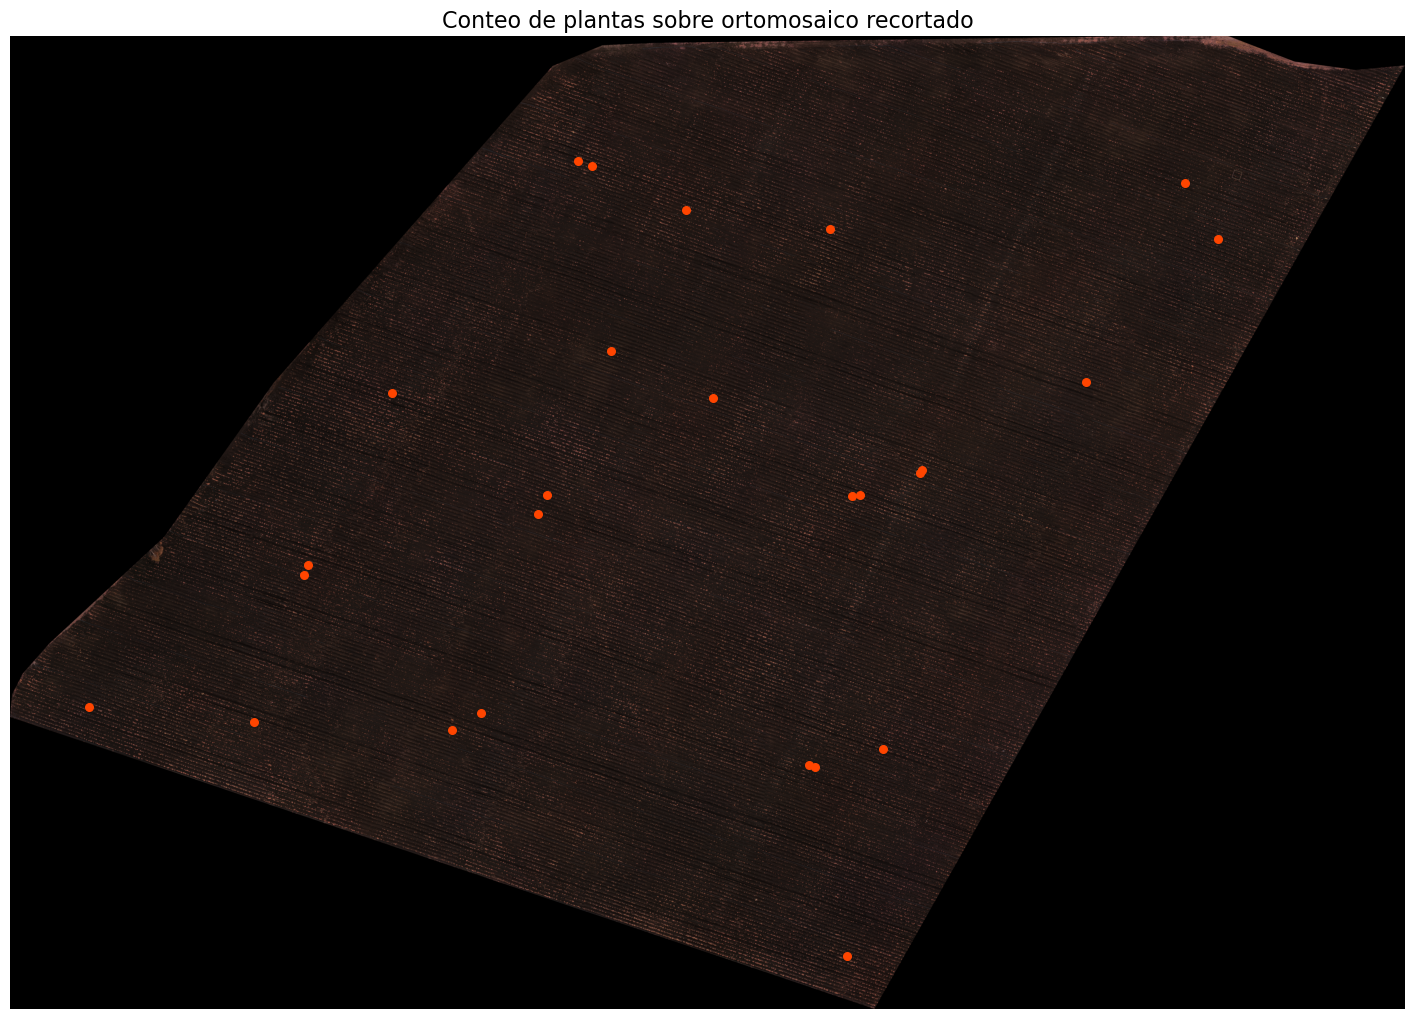

In [20]:
# Guardar raster recortado y abrirlo desde cero
with rasterio.open("Rst/Mosaico_recortado_04_05.tif", "w", **meta) as dst:
    dst.write(ortomosaico_clip)

# Reabrir como imagen RGB
with rasterio.open("Rst/Mosaico_recortado_04_05.tif") as src:
    rgb = np.stack([src.read(5), src.read(3), src.read(2)], axis=-1).astype("float32")
    rgb /= np.max(rgb)
    extent = plotting_extent(src)

# Mostrar ortomosaico recortado y puntos
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(rgb, extent=extent, origin='upper')
pointData.plot(ax=ax, color='orangered', markersize=30)
ax.set_title("Conteo de plantas sobre ortomosaico recortado", fontsize=16)
plt.axis('off')
plt.show()

### Seleccion de la banda

En esta celda se seleccionara una de las bandas que tiene el sensor, en este caso se selecciona la banda verde

In [21]:
papaRaster = rasterio.open("Rst/Mosaico_recortado_04_05.tif")

In [22]:
#selected band: green
greenBand = papaRaster.read(2)


### Extracción valor de punto del ráster
Se extrae las coordenadas "x" e "y" de geometrías de puntos en un GeoDataFrame (pointData), y luego obtiene las filas y columnas correspondientes en un ráster (papaRaster)


In [23]:
#extract point value from raster
surveyRowCol = []
for index, values in pointData.iterrows():
    x = values['geometry'].xy[0][0]
    y = values['geometry'].xy[1][0]
    row, col = papaRaster.index(x,y)
    print("Point N°:%d corresponds to row, col: %d, %d"%(index,row,col))
    surveyRowCol.append([row,col])

Point N°:0 corresponds to row, col: 3792, 4180
Point N°:1 corresponds to row, col: 3641, 4252
Point N°:2 corresponds to row, col: 3648, 6674
Point N°:3 corresponds to row, col: 3641, 6735
Point N°:4 corresponds to row, col: 3464, 7208
Point N°:5 corresponds to row, col: 3443, 7231
Point N°:6 corresponds to row, col: 5655, 6921
Point N°:7 corresponds to row, col: 5797, 6382
Point N°:8 corresponds to row, col: 5780, 6331
Point N°:9 corresponds to row, col: 5366, 3733
Point N°:10 corresponds to row, col: 5497, 3505
Point N°:11 corresponds to row, col: 1535, 6502
Point N°:12 corresponds to row, col: 1376, 5360
Point N°:13 corresponds to row, col: 990, 4503
Point N°:14 corresponds to row, col: 1031, 4612
Point N°:15 corresponds to row, col: 1162, 9312
Point N°:16 corresponds to row, col: 1614, 9574
Point N°:17 corresponds to row, col: 2744, 8525
Point N°:18 corresponds to row, col: 7296, 6636
Point N°:19 corresponds to row, col: 5442, 1937
Point N°:20 corresponds to row, col: 5318, 626
Poin

### Imagenes plantilla
 Primero se imprime la cantidad de imágenes plantilla que se generarán a partir de las posiciones almacenadas en la lista surveyRowCol. Esta lista contiene las coordenadas de fila y columna en el ráster que corresponden a puntos de interés previamente identificados en un conjunto de datos geoespaciales. El número total de puntos se considera equivalente al número de imágenes plantill
Posteriormentete, se define una variable llamada radio con un valor de 15. Esta variable representa el radio de análisis que se utilizará para extraer una ventana centrada en cada punto del ráster. El valor del radio determina el tamaño de cada ventana de análisis, la cual tendrá dimensiones de (2×𝑟𝑎𝑑𝑖𝑜+1)×(2×𝑟𝑎𝑑𝑖𝑜+1)(2×radio+1)×(2×radio+1), es decir, 31 por 31 píxeles. Estas ventanas probablemente serán utilizadas para realizar análisis localizados, como extracción de características o comparación con otras regiones del ráster..

In [24]:
# number of template images
print('Number of template images: %d'%len(surveyRowCol))
# define ratio of analysis
radio = 15

Number of template images: 26


### Muestra todos los puntos de interés
Este fragmento de código genera una visualización de todos los puntos de interés sobre la banda verde del ráster (greenBand), mostrando para cada punto una subimagen centrada en su ubicación. Se crea una figura con varias subgráficas, una por cada punto en surveyRowCol, en las que se dibuja la imagen de fondo junto con una cruz que indica la posición del punto. Cada subgráfica muestra una ventana de tamaño definido por el radio, y se desactivan los ejes para una presentación más limpia. El objetivo es asegurar que todas las subimágenes estén completas, ya que si alguna se encuentra demasiado cerca del borde del ráster, no se podría generar adecuadamente y el modelo no funcionaría.

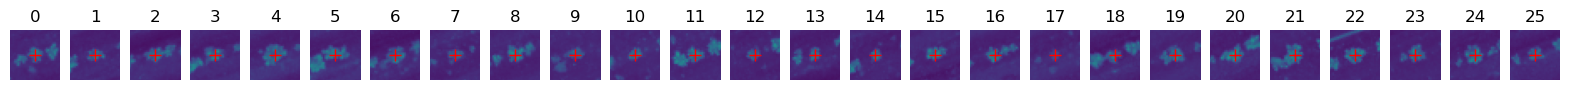

In [25]:
#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(1, len(surveyRowCol),figsize=(20,5))

for index, item in enumerate(surveyRowCol):
    row = item[0]
    col = item[1]
    ax[index].imshow(greenBand)
    ax[index].plot(col,row,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[index].set_xlim(col-radio,col+radio)
    ax[index].set_ylim(row-radio,row+radio)
    ax[index].axis('off')
    ax[index].set_title(index)

### Verificación de la imagen con la plantilla
Este fragmento de código tiene como objetivo generar una serie de imágenes plantilla a partir de cada punto de interés y sus rotaciones, que posteriormente se usarán para hacer coincidencias (matching) con otras imágenes.
Se construye una lista de imágenes plantilla (templateBandList) para cada punto de interés previamente identificado. A partir de cada coordenada en surveyRowCol, se extrae una ventana centrada en el punto sobre la banda verde (greenBand) y se almacena como la imagen original. Luego, se extrae una región más amplia alrededor del punto, que se rota en tres ángulos distintos (30°, 60° y 90°). Cada rotación se realiza sobre una ventana del doble del tamaño para evitar pérdida de información en los bordes, y después se recorta la sección central para igualarla al tamaño original. Todas estas imágenes —la original y las tres rotadas— se visualizan en una fila mediante subgráficas y se agregan a una lista general que servirá como base para tareas de comparación o reconocimiento.

C:\Users\seflo\AppData\Local\Temp\ipykernel_3040\587168534.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))


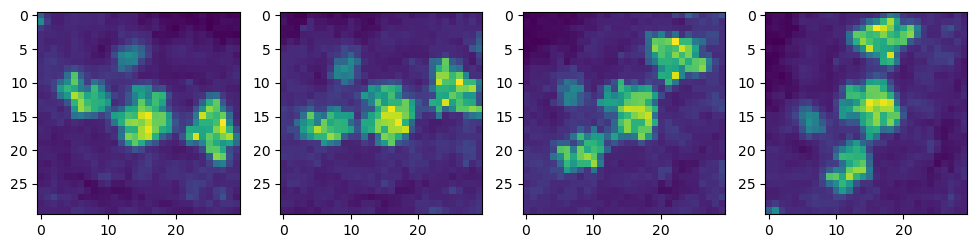

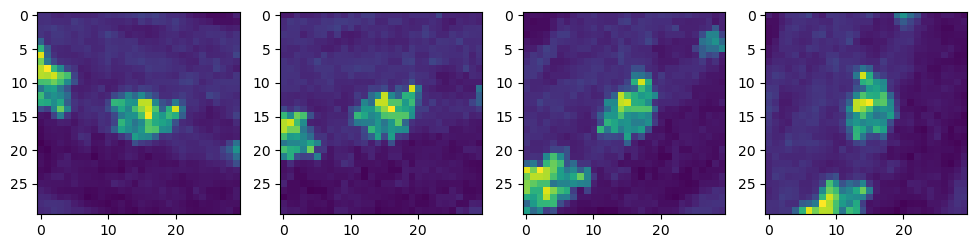

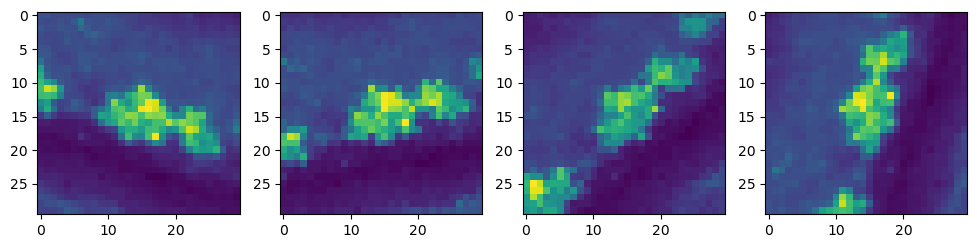

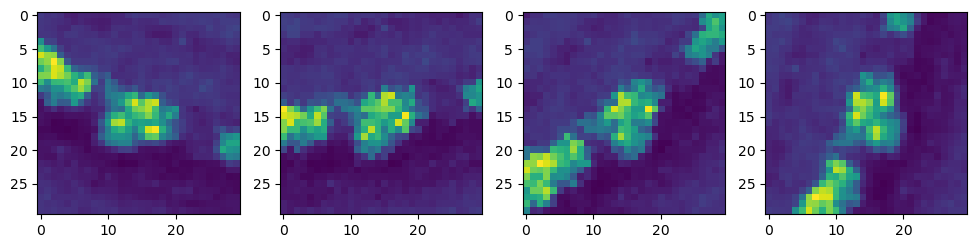

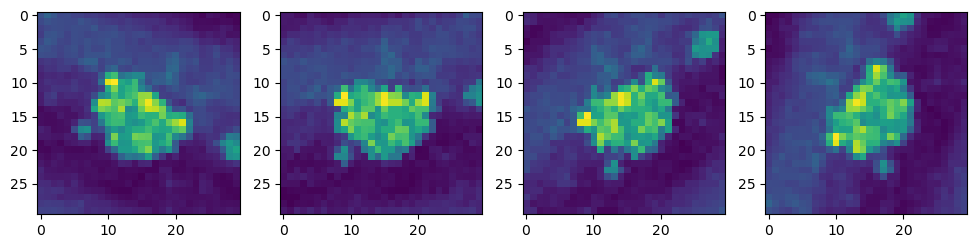

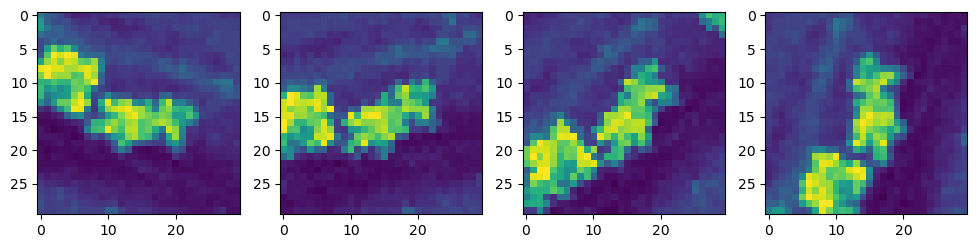

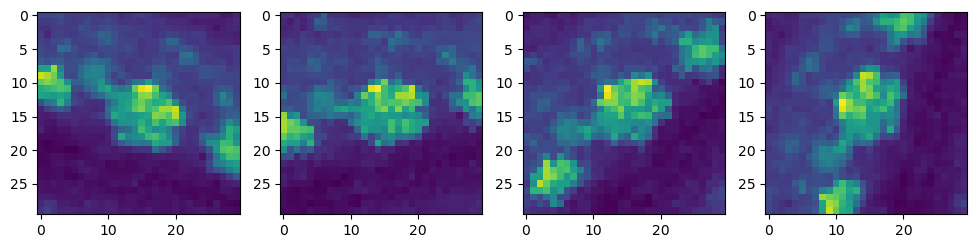

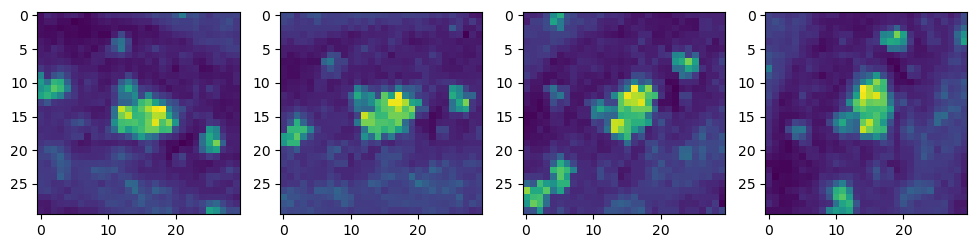

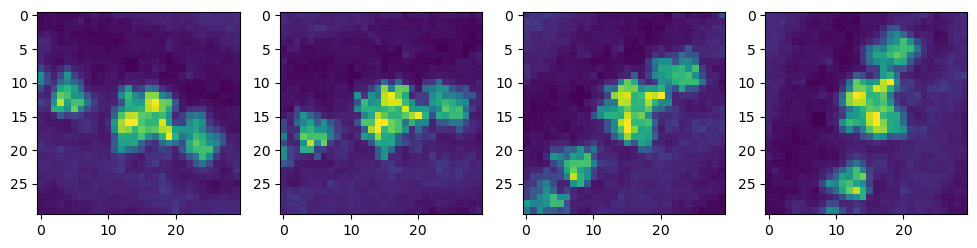

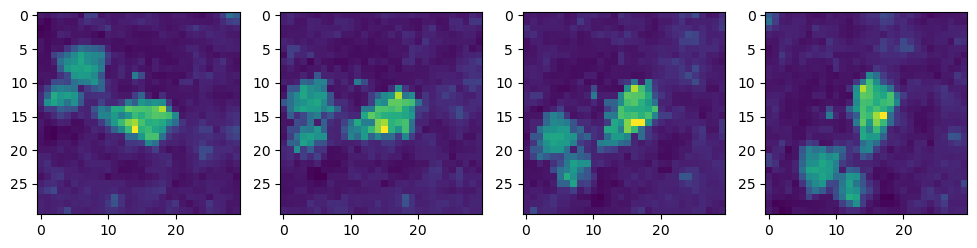

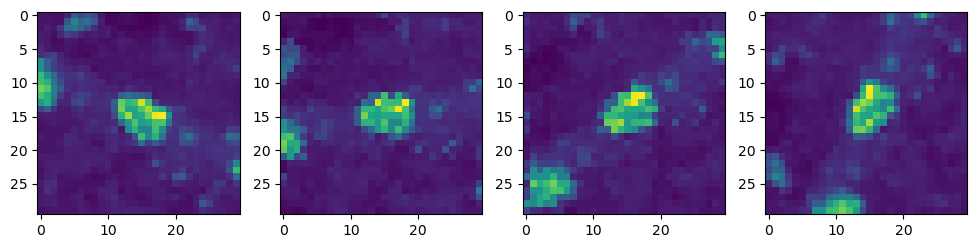

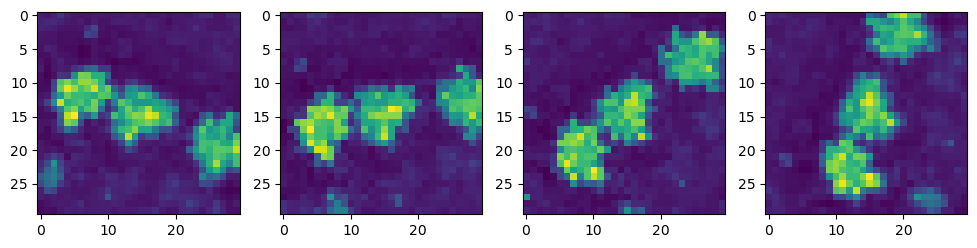

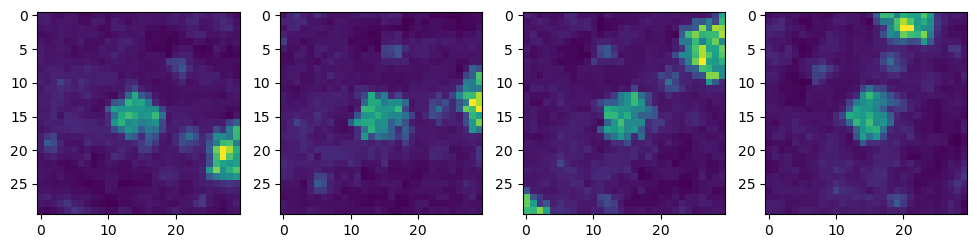

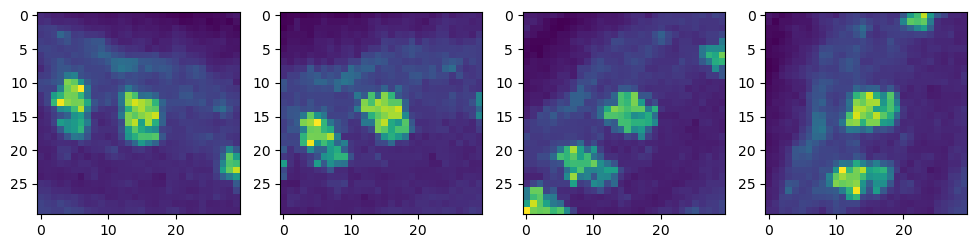

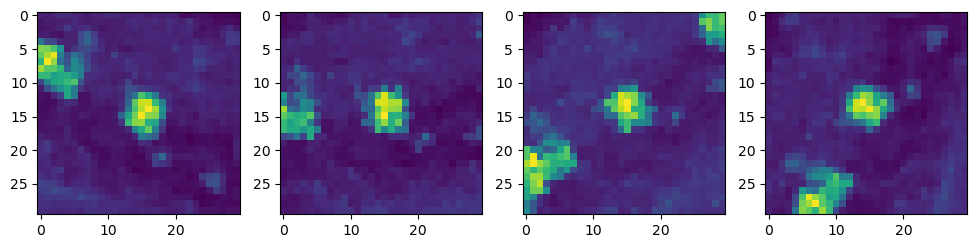

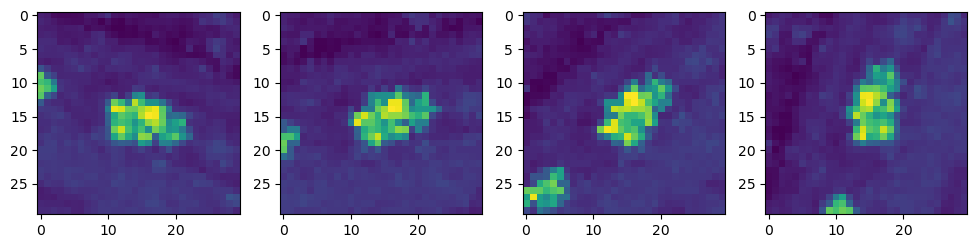

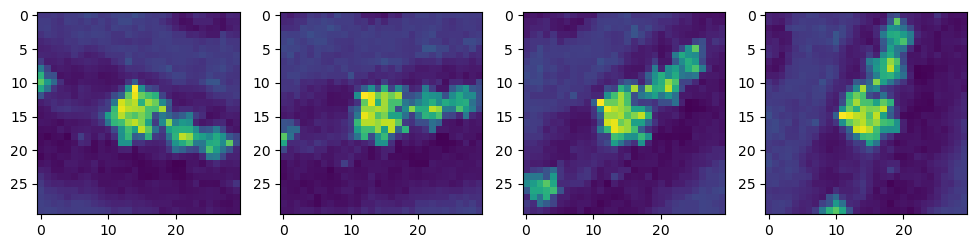

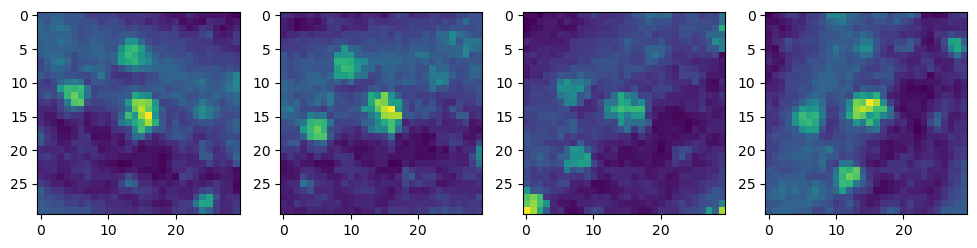

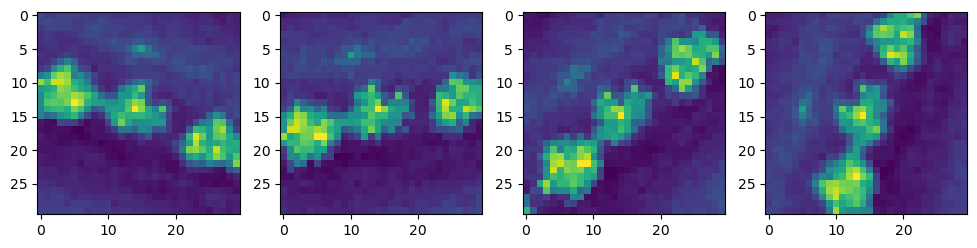

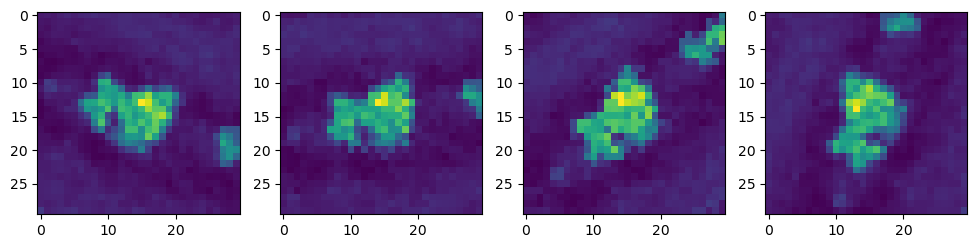

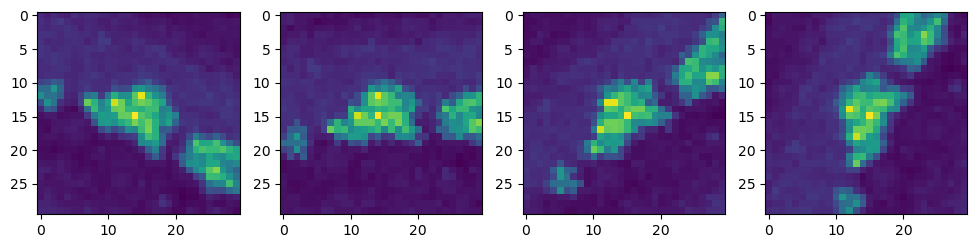

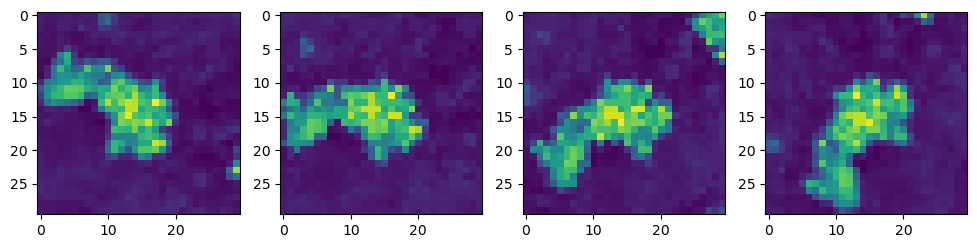

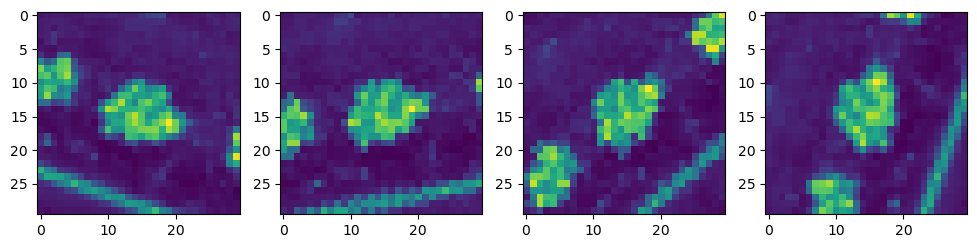

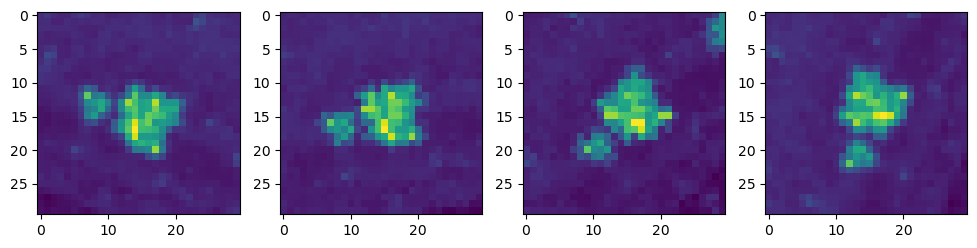

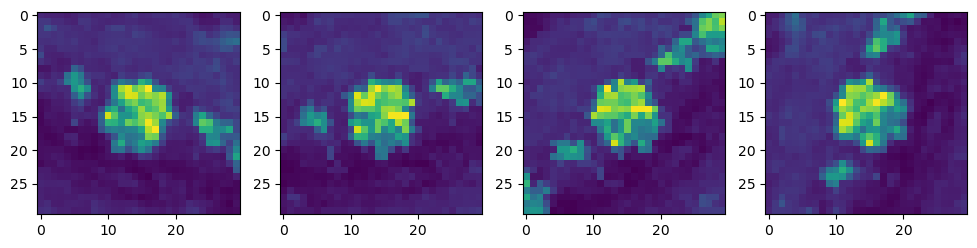

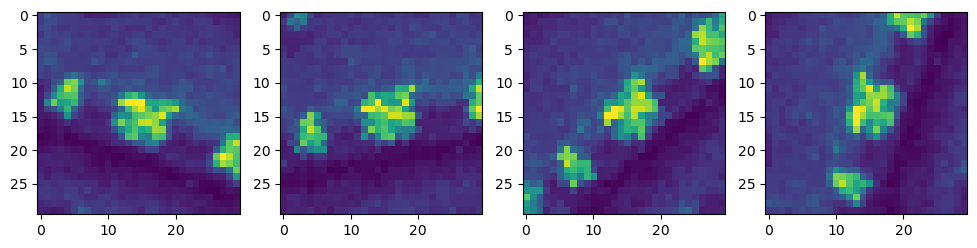

In [26]:
# Match the image to the template

listaresultados = []

templateBandList = []
for rowCol in surveyRowCol:
    imageList = []
    row = rowCol[0]
    col = rowCol[1]
    #append original band
    imageList.append(greenBand[row-radio:row+radio, col-radio:col+radio])
    #append rotated images
    templateBandToRotate = greenBand[row-2*radio:row+2*radio, col-2*radio:col+2*radio]
    rotationList = [i*30 for i in range(1,4)]
    for rotation in rotationList:
        rotatedRaw = Image.fromarray(templateBandToRotate)
        rotatedImage = rotatedRaw.rotate(rotation)
        imageList.append(np.asarray(rotatedImage)[radio:-radio,radio:-radio])
    #plot original and rotated images
    fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))
    for index, item in enumerate(imageList):
        ax[index].imshow(imageList[index])
    #add images to total list
    templateBandList+=imageList

### Coincidencia de la imagen de la plantilla con la ortofoto
En este bloque de código se lleva a cabo el proceso de coincidencia (matching) entre las imágenes plantilla generadas previamente y la ortofoto representada por la banda verde (greenBand). Para cada imagen plantilla en templateBandList, se aplica la función match_template de skimage, que compara la plantilla contra la imagen completa y produce una matriz de similitud. Para reducir la cantidad de falsos positivos, se filtran únicamente aquellas coincidencias cuya similitud supera el percentil 99.96 del resultado. Las posiciones filtradas se convierten de coordenadas de fila y columna a coordenadas geográficas (x, y) mediante el método xy() del ráster original (papaRaster). Finalmente, cada par de coordenadas se almacena en la lista matchXYList, que contiene todos los puntos donde se ha detectado una posible coincidencia con alguna de las plantillas.


In [27]:
# match the template image to the orthophoto
matchXYList = []
for index, templateband in enumerate(templateBandList):
    if index%10 == 0:
        print('Match template ongoing for figure Nº %d'%index)
    matchTemplate = match_template(greenBand, templateband, pad_input=True)
    matchTemplateFiltered = np.where(matchTemplate > np.quantile(matchTemplate, 0.99995))
    for item in zip(matchTemplateFiltered[0],matchTemplateFiltered[1]):
        x, y = papaRaster.xy(item[0], item[1])
        matchXYList.append([x,y])


Match template ongoing for figure Nº 0
Match template ongoing for figure Nº 10
Match template ongoing for figure Nº 20
Match template ongoing for figure Nº 30
Match template ongoing for figure Nº 40
Match template ongoing for figure Nº 50
Match template ongoing for figure Nº 60
Match template ongoing for figure Nº 70
Match template ongoing for figure Nº 80
Match template ongoing for figure Nº 90
Match template ongoing for figure Nº 100


### Trazar puntos interpretados sobre la imagen
Se visualiza los resultados del proceso de coincidencia proyectando los puntos identificados sobre la ortofoto. Primero, se convierte la lista de coordenadas geográficas matchXYList en un arreglo NumPy para facilitar su manipulación. Luego, utiliza matplotlib para crear una figura de gran tamaño y traza todos los puntos como círculos pequeños, semitransparentes y de color naranja rojizo (orangered). Finalmente, superpone la imagen del ráster original (papaRaster) como fondo usando la función show() de rasterio.plot, lo que permite ver claramente dónde se han detectado coincidencias en el espacio geográfico.

<Axes: >

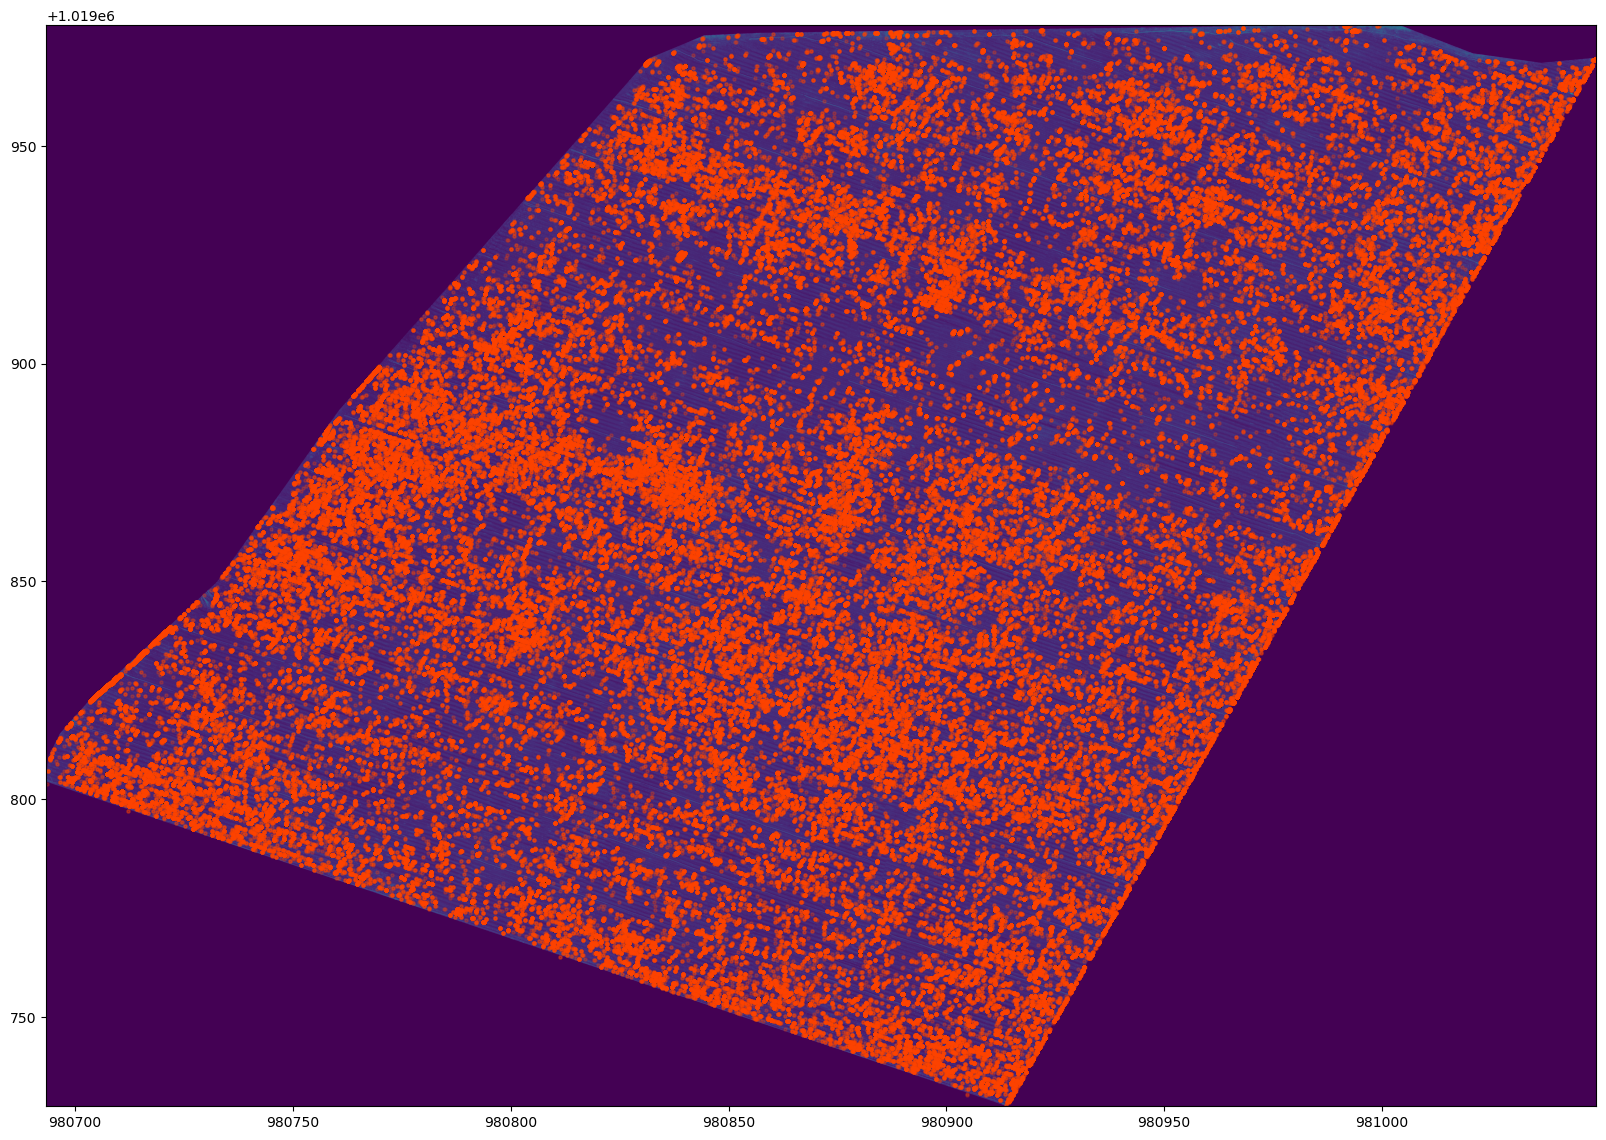

In [28]:
# plot interpreted points over the image
fig, ax = plt.subplots(figsize=(20, 20))
matchXYArray = np.array(matchXYList)
ax.scatter(matchXYArray[:,0],matchXYArray[:,1], marker='o',c='orangered', s=5, alpha=0.25)
show(papaRaster, ax=ax)

### Análisis de conglomerados
Se aplica el algoritmo de agrupamiento BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) para identificar agrupaciones espaciales en los puntos detectados como coincidencias. Utilizando el conjunto de coordenadas matchXYArray, crea un modelo con parámetros personalizados: un branching_factor alto para manejar eficientemente grandes cantidades de datos, un threshold muy bajo (2e-5) que define la distancia máxima entre puntos en un mismo subgrupo, y n_clusters=None para permitir que el algoritmo determine automáticamente el número de grupos según la distribución de los datos. Al finalizar el ajuste del modelo, se accede a los centros de los subclusters identificados a través del atributo subcluster_centers_, los cuales representan la localización central de cada conglomerado espacial de coincidencias.

In [82]:
# cluster analysis
from sklearn.cluster import Birch
brc = Birch(branching_factor=50, n_clusters=None, threshold=0.01)
brc.fit(matchXYArray)
birchPoint = brc.subcluster_centers_
birchPoint

Número de plantas detectadas: 314930


In [ ]:
print("Número de plantas detectadas:", len(birchPoint))

### Trazar puntos agrupados
Se genera una visualización de los centros de conglomerados detectados mediante el algoritmo BIRCH, sobre la ortofoto original. Para ello, crea una figura de gran tamaño y añade un solo subgráfico donde se representan los puntos centrales de los clústeres (birchPoint) como pequeños círculos de color naranja rojizo (orangered), con tamaño mínimo para no saturar la imagen. Estos puntos representan las ubicaciones donde las coincidencias fueron más densas o frecuentes. Finalmente, se superpone la ortofoto utilizando show(papaRaster, ax=ax) para proporcionar el contexto geoespacial y facilitar la interpretación visual de los resultados.

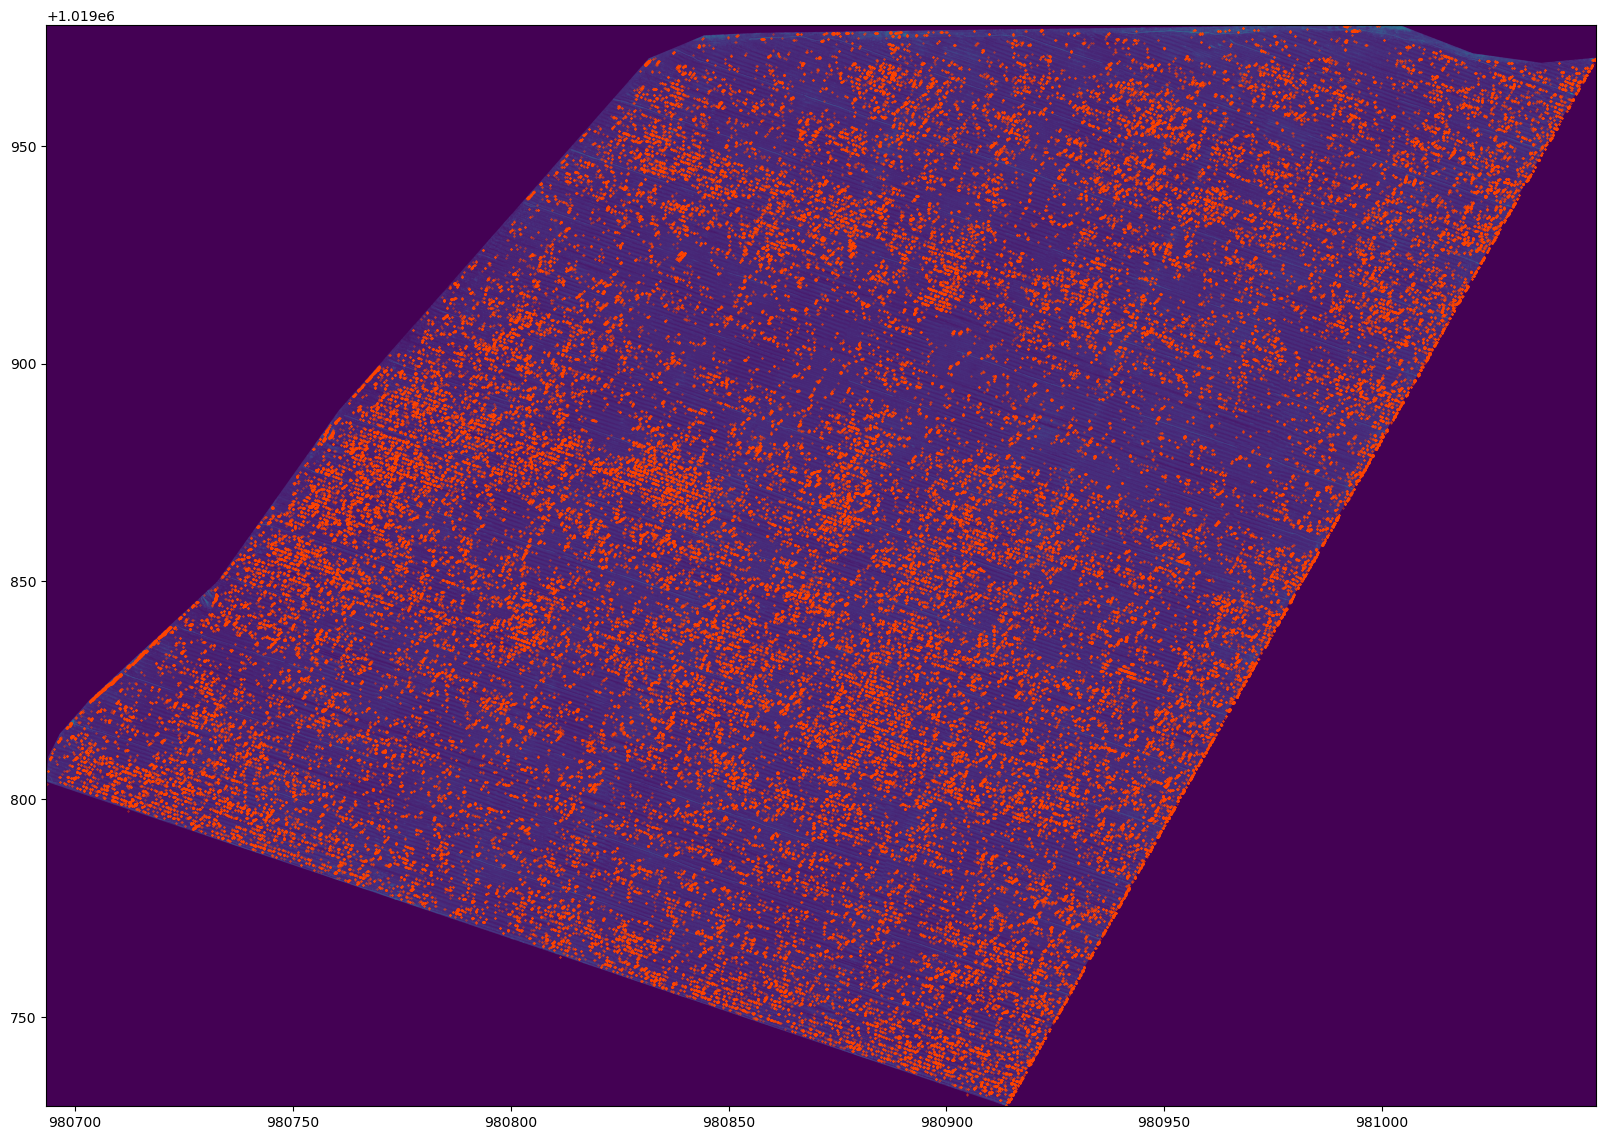

In [83]:
# plot clustered points
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=0.1)
show(papaRaster, ax=ax)
plt.show()

### Exportar CSV

Se exporta las coordenadas de los centros de los conglomerados, almacenadas en birchPoint, a un archivo CSV utilizando la función np.savetxt(). El archivo se guarda en la ruta Txt/birchPoints.csv y las coordenadas se separan por comas (,). Este archivo CSV puede ser utilizado para realizar un análisis posterior, importar los puntos a otros programas o compartir los resultados con otros usuarios.

In [77]:
import os

# Crear la carpeta si no existe
os.makedirs("Txt", exist_ok=True)

# Ahora guardar el CSV
np.savetxt("Txt/birchPoints.csv", birchPoint, delimiter=",")

In [78]:
# save xy to a csv file
np.savetxt("Txt/birchPoints.csv", birchPoint, delimiter=",")

In [79]:
# Cargar el raster clip
with rasterio.open("Rst/Ortomosaico_recortado.tif") as src:
    # Leer puntos
    birchPoints = np.loadtxt("Txt/birchPoints.csv", delimiter=",")
    
    # Convertir (fila, columna) a (X, Y) geográficas
    coords = [src.transform * (col, row) for col, row in birchPoints]

# Ahora puedes guardar las coordenadas
np.savetxt("Txt/birchPoints_xy.csv", coords, delimiter=",", header="X,Y", comments="")
print(f"Total de puntos exportados: {len(coords)}")

Total de puntos exportados: 227361
